Installing required libraries 

In [ ]:
!pip uninstall h2o
!pip3 install http://h2o-release.s3.amazonaws.com/h2o/rel-zz_kurka/2/Python/h2o-3.40.0.2-py2.py3-none-any.whl
!pip install emoji

Improting libraries

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.automl import H2OAutoML
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import re
import string
import nltk
import emoji
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Preprocessing

## Preprocessing datasets

Random dataset

In [ ]:
#Dataset of random tweets labelled zero
random_data=pd.read_csv("test.csv")
print(f"Dataset shape:{random_data.shape}")
random_data.head(2)

In [ ]:
random_data = random_data.rename(columns={"tweet":"text"})
#selecting a random susbet
random_data = random_data.sample(n=50000, random_state=42).reset_index(drop=True)
random_data.drop(columns="index",inplace=True)
random_data["label"] = 0
random_data["disaster_type"] = "None"

random_data.to_csv("random_data_fixed.csv")

Harvey dataset

In [ ]:
Harvey_data = pd.read_csv("Harvey_missing_ids_50K1.csv")
Harvey_data.head(2)

In [ ]:
Harvey_data = Harvey_data.rename(columns={"Tweet":"text"})
Harvey_data.drop(columns="Date", inplace=True)
Harvey_data["label"] = 1
Harvey_data["disaster_type"] = "Hurricane"
Harvey_data.to_csv("Harvey_data_fixed.csv")


Nepal dataset

In [ ]:
df = pd.read_csv("2015-nepal-earthquake-test.csv",encoding='ISO-8859-1')
df['label'] = df['label'].apply(lambda x: 1 if x == 'relevant' else 0)
df["disaster_type"] = "Earthquake"
df.to_csv("2015_nepal_earthquake_test_fixed.csv")

df = pd.read_csv("2015-nepal-earthquake-train.csv",encoding='ISO-8859-1')
df['label'] = df['label'].apply(lambda x: 1 if x == 'relevant' else 0)
df["disaster_type"] = "Earthquake"
df.to_csv("2015_nepal_earthquake_train_fixed.csv")

## Data cleaning and merging

In [ ]:
files = [
    "2011Tornado_Summary.csv",
    "2013Floods_Summary.csv",
    "2016Blizzard_Summary.csv",
    "2017Hurricane_Summary.csv",
    "2018Michael_Summary.csv", #Hurricane
    "2018Wildfires_Summary.csv",
    "2019Dorian_Summary.csv", #Hurricane
    "2015_nepal_earthquake_train_fixed.csv",
    "2015_nepal_earthquake_test_fixed.csv",
    "Harvey_data_fixed.csv",
    "random_data_fixed.csv"
]
disaster_types_label = {
    "2011Tornado_Summary.csv": "Tornado",
    "2013Floods_Summary.csv": "Floods",
    "2016Blizzard_Summary.csv": "Blizzard",
    "2017Hurricane_Summary.csv": "Hurricane",
    "2018Michael_Summary.csv": "Hurricane",
    "2018Wildfires_Summary.csv": "Wildfires",
    "2019Dorian_Summary.csv": "Hurricane",
    "2015_nepal_earthquake_train_fixed.csv": "Earthquake",
    "2015_nepal_earthquake_test_fixed.csv": "Earthquake",
    "Harvey_data_fixed.csv": "Hurricane",
    "random_data_fixed.csv": "Unknown"  }

def get_disaster_type(filename):
    #Return the pre-mapped disaster type
    return disaster_types_label.get(filename, "Unknown")

Text Cleaining pipeline

In [ ]:

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#Convert emoji into words
def convert_emoji(text):
    return emoji.demojize(text, delimiters=(" ", " "))

#Clean text (no lemmatization)
def basic_clean(text):
    if pd.isna(text):
        return ""
    #Kept nubers and punctation as they could indicate emerginces
      #ex 911, or  fire!!!

    #remove retweet mentions 'Rt'
    text = re.sub(r"\bRT\b\s*[:\s]*", '', text)

    text = text.lower()

    text = convert_emoji(text)
    #remove any url
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    #remove mentions
    text = re.sub(r"@\w+", '', text)
    #keep hastags but remove the hash sign,remove non ascii charchter after translating the emjois, remove stop words,normalize white space
    text = re.sub(r"#", '', text)


    #Normlaize white space
    text = re.sub(r'\s+', ' ', text).strip()

    #remove punct. keep ! and ?
    text = remove_selected_punctuation(text)

    #remove non ascii charchter after translating the emjois
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove stop words
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return text

def remove_selected_punctuation(text, keep="!?"):
    punctuation_to_remove = ''.join(c for c in string.punctuation if c not in keep)
    return re.sub(f"[{re.escape(punctuation_to_remove)}]", "", text)

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

def clean_dataframe(df, text_column='text'):
    df['clean_text'] = df[text_column].apply(basic_clean)

    df['lemmatized_text'] = df['clean_text'].apply(lemmatize_text)
    return df


Merging and cleaining pipeline

In [ ]:
dfs = []
keep_cols = ['text','clean_text','lemmatized_text' ,"disaster_type",'label']

for file in files:
    file_extension = os.path.splitext(file)[1].lower()

    if file_extension == '.csv':
        df = pd.read_csv(file)
    else:
        raise ValueError(f"Unsupported file type: {file_extension}")

    df.columns = df.columns.str.strip().str.lower()

    if df.isna().any().any():
        print(f"Warning: '{file}' contains NaN values.")

    if 'sentiment' in df.columns and 'label' not in df.columns:
        df.rename(columns={'sentiment': 'label'}, inplace=True)
    #Cleaning the text
    df = clean_dataframe(df)

    if 'tweet_id' in df.columns:
        df['tweet_id'] = pd.to_numeric(df['tweet_id'], errors='coerce')
        df.dropna(subset=['tweet_id'], inplace=True)

        before_column_removal_duplicates = df.duplicated(subset=['tweet_id'], keep="first")

        if before_column_removal_duplicates.any():
            print(f"Warning: Duplicates found in '{file}' before removing columns (based on 'tweet_id' column).")
            print(f"Number of duplicates in {file} df is {before_column_removal_duplicates.sum()}")
    else:

        before_column_removal_duplicates = df.duplicated(subset=['clean_text'], keep="first")
        if before_column_removal_duplicates.any():
            print(f"Warning: Duplicates found in '{file}' before removing columns (based on 'text' column).")
            print(f"Number of duplicates in {file} df is {before_column_removal_duplicates.sum()}")
    print(file)
    #remove duplicates
    df = df[~before_column_removal_duplicates]

    #Keepinf wanted columns
    existing_cols = [col for col in keep_cols if col in df.columns]
    df = df[existing_cols]
    df.reset_index(drop=True, inplace=True)
    #Adding distater type
    if "disaster_type" not in df.columns:
        disaster_type = get_disaster_type(file)
        df["disaster_type"] = disaster_type

    dfs.append(df)
#adding dfs togther
combined_df = pd.concat(dfs, ignore_index=True)

#Final check for duplicates
after_combining_duplicates = combined_df.duplicated(subset=['clean_text'], keep="first")

if after_combining_duplicates.any():
    print("Warning: Duplicates found after combining all dataframes based on 'text'.")
    print(f"Number of duplicates in final df is {after_combining_duplicates.sum()}")

#Removing duplciates
combined_df = combined_df[~after_combining_duplicates]

# Reset index after combining and removing duplicates
combined_df.reset_index(drop=True, inplace=True)
print(f"Final Df shape: {combined_df.shape}")



In [ ]:
print(f"Combined dataset shape: {combined_df.shape}")
combined_df.head(20)

In [ ]:
combined_df.value_counts(subset="label")

In [ ]:
combined_df.to_csv("Cleaned_Data.csv")

# H2O

1 - we need to understand when using H2O: all the
data is on the cluster (the server), not on our client. Even when client and cluster are
the same machine and we use H2o for applying ML on big data

2 - Therefore, whenever we want to train a model, or make a prediction, we have to get
the data into the H2O cluster;the first line has created a frame on the cluster called
“iris_wheader.csv.”

3 - HEX format
Records made up of hexadecimal numbers that represent machine language code or constant data. In H2O, data must be parsed into .hex format before you can perform operations on it.

4 - Understanding H2O more: http://s3.amazonaws.com/h2o-release/h2o-classic/master/1761/docs-website/resources/glossary.html

## Starting H2O

In [ ]:
import h2o
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp66gjc4ip
  JVM stdout: /tmp/tmp66gjc4ip/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp66gjc4ip/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,"2 years, 1 month and 7 days"
H2O_cluster_name:,H2O_from_python_unknownUser_6sfo0e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Reading Dataset

In [ ]:
dataset = "/content/Cleaned_Data_Final.csv"

In [ ]:
data = h2o.import_file(dataset)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
import h2o
h2o.init()


label_counts = data["label"].table().as_data_frame()
print(label_counts)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,6 mins 24 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,"2 years, 1 month and 7 days"
H2O_cluster_name:,H2O_from_python_unknownUser_6sfo0e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.943 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


   label  Count
0      0  61277
1      1  59571


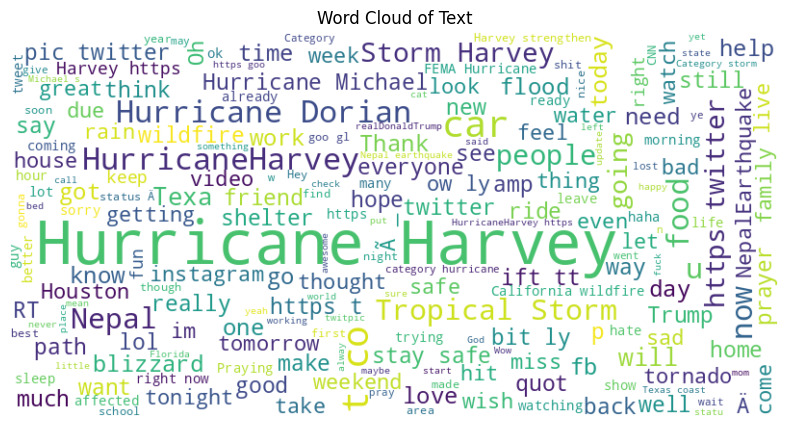

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data_df = data.as_data_frame()

texts = " ".join(
    str(text) for text in data_df["text"].tolist()
)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=True,
).generate(texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Text")
plt.show()

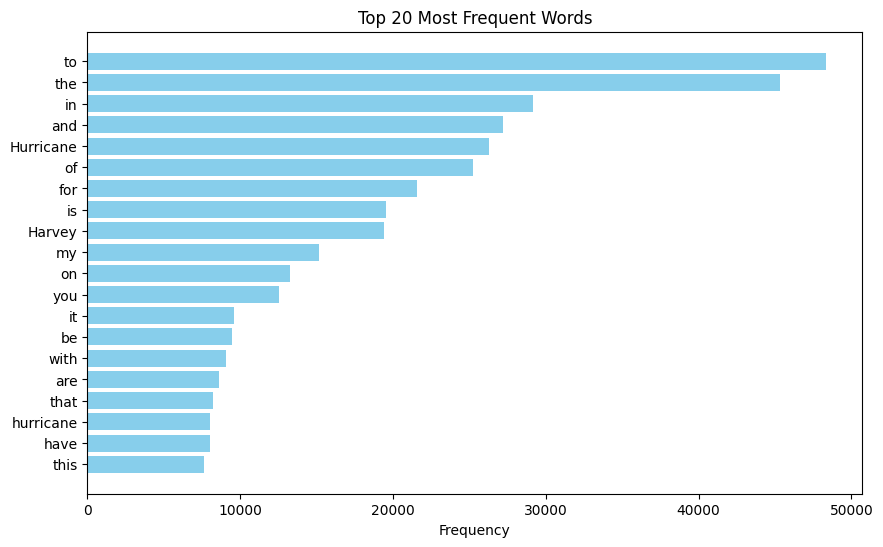

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

words = []
for text in texts.split():
    if len(text) > 1:
        words.append(text)

word_freq = Counter(words)
top_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))
plt.barh(top_words['Word'], top_words['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.gca().invert_yaxis()
plt.show()

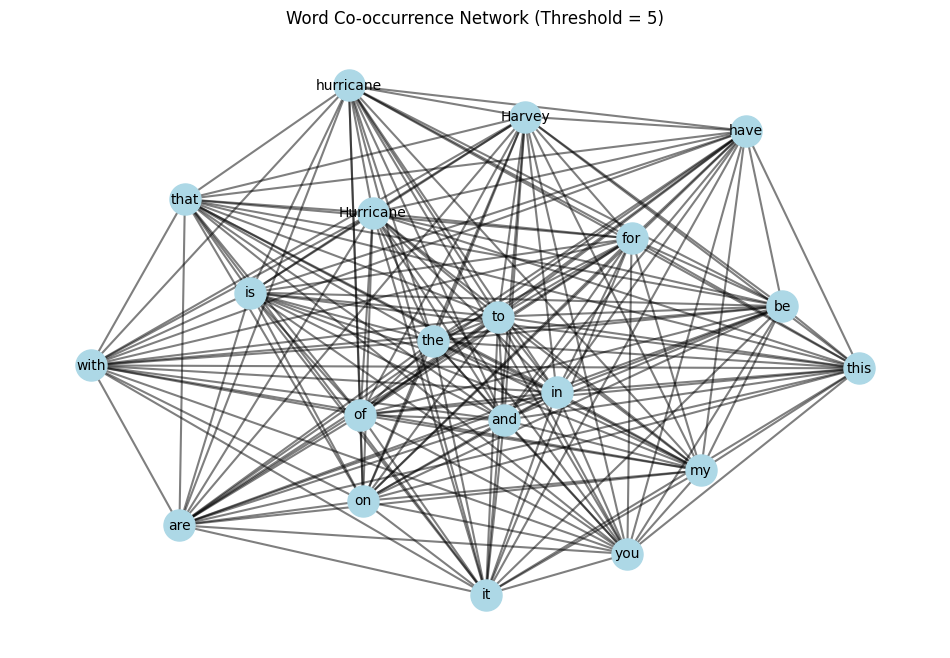

In [ ]:
import networkx as nx
from itertools import combinations

co_occur = pd.DataFrame(0, index=top_words['Word'], columns=top_words['Word'])

for text in data_df["text"]:
    tokens = text.split()
    for (w1, w2) in combinations(set(tokens), 2):
        if w1 in co_occur.index and w2 in co_occur.columns:
            co_occur.loc[w1, w2] += 1
            co_occur.loc[w2, w1] += 1

G = nx.Graph()
for word in top_words['Word']:
    G.add_node(word)

threshold = 5
for w1 in co_occur.index:
    for w2 in co_occur.columns:
        if co_occur.loc[w1, w2] > threshold and w1 != w2:
            G.add_edge(w1, w2, weight=co_occur.loc[w1, w2])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Word Co-occurrence Network (Threshold = 5)")
plt.axis('off')
plt.show()

In [ ]:
texts = data_df["lemmatized_text"].tolist()

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = bert_model.encode(texts, show_progress_bar=True)

embedding_df = pd.DataFrame(embeddings, columns=[f"vec_{i}" for i in range(embeddings.shape[1])])
embedding_df["label"] = data_df["label"]

doc_vectors = h2o.H2OFrame(embedding_df)
doc_vectors["label"] = doc_vectors["label"].asfactor()

Batches:   0%|          | 0/3777 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
final_df = doc_vectors.as_data_frame()

output_file_path = "embeddings_and_labels.csv"
final_df.to_csv(output_file_path, index=False)
print(f"The embeddings and labels have been saved to: {output_file_path}")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
The embeddings and labels have been saved to: embeddings_and_labels.csv


In [ ]:
embedding_df

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_375,vec_376,vec_377,vec_378,vec_379,vec_380,vec_381,vec_382,vec_383,label
0,-0.037860,0.025906,0.083887,0.092461,0.011143,-0.038742,0.020304,-0.067419,-0.105565,0.026052,...,0.045008,-0.012875,-0.095059,0.082856,0.013002,-0.043350,-0.059092,-0.092377,0.027830,1
1,-0.029954,0.026895,0.088083,0.085591,0.001586,-0.029323,0.017216,-0.071754,-0.114578,0.013600,...,0.038204,-0.003160,-0.099703,0.088498,0.013667,-0.048963,-0.051932,-0.090256,0.028173,1
2,0.003476,0.015894,0.084431,0.087014,0.082672,-0.000210,0.061801,-0.094738,-0.024649,-0.025349,...,0.012950,0.000642,-0.039387,-0.008771,0.018240,0.019503,-0.029084,-0.119105,-0.019156,1
3,-0.054720,-0.004746,0.061844,0.033332,-0.035926,-0.043972,0.023909,-0.115461,-0.035144,-0.071825,...,-0.027958,0.028665,-0.034045,0.088217,-0.030942,-0.060068,-0.015168,-0.131214,-0.049115,1
4,-0.046047,0.009186,0.023714,0.094501,0.023755,0.046394,0.023265,-0.081312,-0.055814,-0.053418,...,-0.022818,0.029420,-0.055690,0.124155,-0.004733,-0.040068,-0.030885,-0.074441,0.015447,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120843,0.046927,-0.065147,0.023336,-0.049035,0.050387,0.026904,0.096707,0.022353,-0.014824,0.019473,...,0.026325,-0.001521,-0.021239,0.025901,-0.072490,0.016367,-0.009851,-0.107921,0.039791,0
120844,-0.048790,-0.014363,-0.006682,0.075028,0.085046,-0.013139,0.000314,0.046057,0.027674,0.075226,...,0.007709,0.017170,-0.021360,-0.057427,-0.073737,0.130096,-0.026157,0.004743,0.005464,0
120845,0.007806,-0.042809,0.008201,0.011985,0.030064,0.024551,-0.005270,0.051336,0.024330,-0.038462,...,0.127217,-0.060839,0.013567,0.043368,0.034768,-0.004423,-0.064284,-0.102125,0.027618,0
120846,0.013168,-0.019934,0.041916,-0.089845,-0.054086,0.022966,0.051179,-0.034394,-0.007213,0.047865,...,-0.038502,-0.069664,0.015117,-0.016367,0.059353,0.047928,0.087471,0.023801,0.006637,0


In [ ]:
import h2o
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

h2o.init()

train_val_df, test_df = train_test_split(
    embedding_df,
    test_size=0.2,
    random_state=42,
    stratify=embedding_df["label"]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,
    random_state=42,
    stratify=train_val_df["label"]
)

train_h2o = h2o.H2OFrame(train_df)
val_h2o = h2o.H2OFrame(val_df)
test_h2o = h2o.H2OFrame(test_df)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,39 mins 09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,"2 years, 1 month and 7 days"
H2O_cluster_name:,H2O_from_python_unknownUser_6sfo0e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.250 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Fully connected neural networks

## The Standard

In [ ]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

train_h2o["label"] = train_h2o["label"].asfactor()
val_h2o["label"] = val_h2o["label"].asfactor()
test_h2o["label"] = test_h2o["label"].asfactor()

fcn_model = H2ODeepLearningEstimator(

    hidden=[128, 64, 32, 16, 8],


    epochs=50,
    train_samples_per_iteration=-1,
    reproducible=True,
    seed=42,


    distribution="bernoulli",
    activation="RectifierWithDropout",
    hidden_dropout_ratios=[0.3, 0.2, 0.1, 0.1, 0.0],

    l1=1e-5,
    l2=1e-5,
    input_dropout_ratio=0.1,


    adaptive_rate=True,
    nesterov_accelerated_gradient=True,


    stopping_rounds=5,
    stopping_metric="AUC",
    stopping_tolerance=0.001,


    balance_classes=False,
    max_after_balance_size=1.0,

    model_id="5_layer_dnn_classifier"
)


fcn_model.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

performance = fcn_model.model_performance(test_h2o)
print("Test Performance:")
print(performance)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Test Performance:
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.053454965381965744
RMSE: 0.231203298812897
LogLoss: 0.18193423049725835
Mean Per-Class Error: 0.07267345233310439
AUC: 0.9809321775049298
AUCPR: 0.9806627738698429
Gini: 0.9618643550098596

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5138028792539998
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      11133  1123   0.0916   (1123.0/12256.0)
1      640    11274  0.0537   (640.0/11914.0)
Total  11773  12397  0.0729   (1763.0/24170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513803     0.927481  218
max f2                       0.279853     0.953273  292
max f0point5                 0.808753   

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


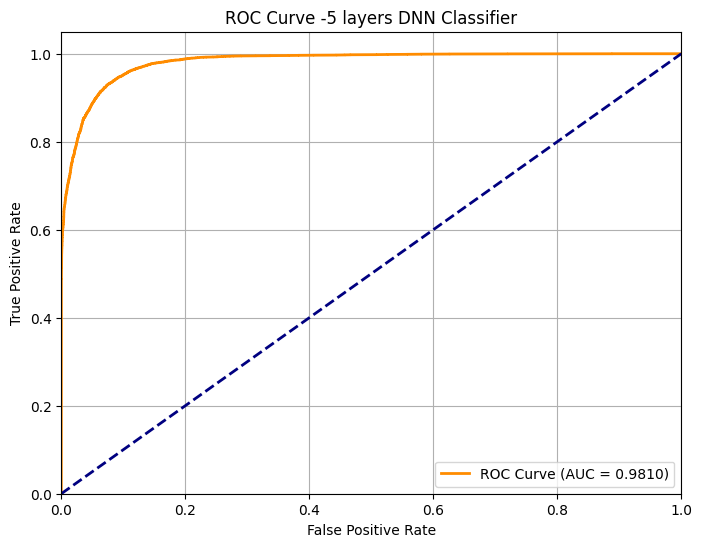

In [ ]:

pred = fcn_model.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -5 layers DNN Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
pred_df = fcn_model.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")


print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy:        0.9254
Macro Precision: 0.9265
Macro Recall:    0.9258
Macro F1-score:  0.9254


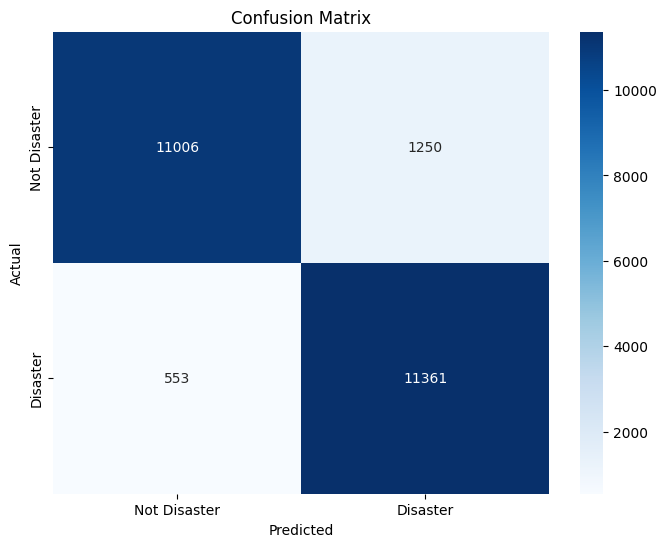

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## More layers

In [ ]:

fcn_model = H2ODeepLearningEstimator(
    hidden=[128, 64, 32, 16, 8, 4],

    epochs=50,
    train_samples_per_iteration=-1,
    reproducible=True,
    seed=42,

    distribution="bernoulli",
    activation="RectifierWithDropout",
    hidden_dropout_ratios=[0.3, 0.2, 0.1, 0.1, 0.1, 0],

    l1=1e-5,
    l2=1e-5,
    input_dropout_ratio=0.1,

    adaptive_rate=True,
    nesterov_accelerated_gradient=True,

    stopping_rounds=5,
    stopping_metric="AUC",
    stopping_tolerance=0.001,

    balance_classes=False,
    max_after_balance_size=1.0,

    model_id="6_layer_dnn_classifier"
)


fcn_model.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

performance = fcn_model.model_performance(test_h2o)
print("Test Performance:")
print(performance)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Test Performance:
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.054041274483063895
RMSE: 0.23246779235641202
LogLoss: 0.18640414906606403
Mean Per-Class Error: 0.07269121041966996
AUC: 0.980423541527597
AUCPR: 0.9801083785545088
Gini: 0.9608470830551941

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5138943131450604
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      11184  1072   0.0875   (1072.0/12256.0)
1      690    11224  0.0579   (690.0/11914.0)
Total  11874  12296  0.0729   (1762.0/24170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513894     0.92722   216
max f2                       0.082248     0.952292  351
max f0point5                 0.722241  

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


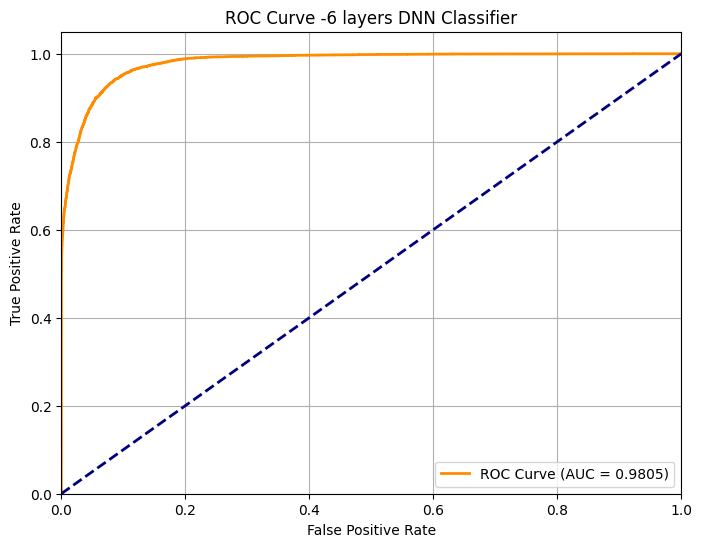

In [ ]:
pred = fcn_model.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -6 layers DNN Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
pred_df = fcn_model.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")



print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy:        0.9256
Macro Precision: 0.9268
Macro Recall:    0.9260
Macro F1-score:  0.9256


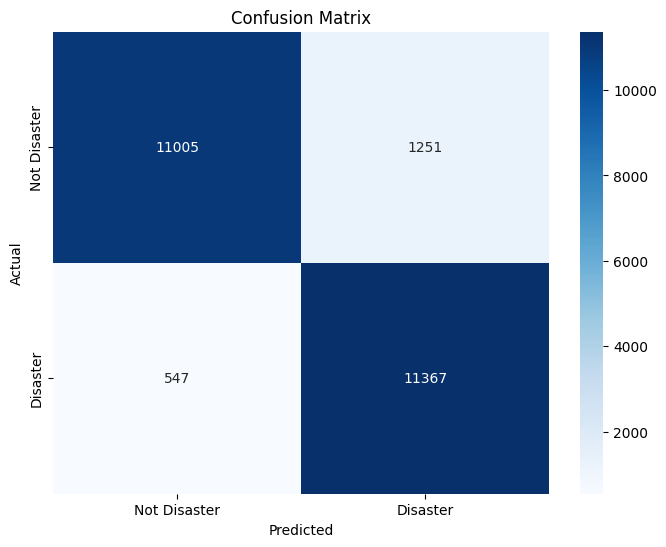

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## with more neurons


In [ ]:
fcn_model = H2ODeepLearningEstimator(

    hidden=[256, 128, 64, 32, 16],


    epochs=50,
    train_samples_per_iteration=-1,
    reproducible=True,
    seed=42,


    distribution="bernoulli",
    activation="RectifierWithDropout",
    hidden_dropout_ratios=[0.3, 0.2, 0.1, 0.1, 0.0],

    l1=1e-5,
    l2=1e-5,
    input_dropout_ratio=0.1,


    adaptive_rate=True,
    nesterov_accelerated_gradient=True,


    stopping_rounds=5,
    stopping_metric="AUC",
    stopping_tolerance=0.001,

    balance_classes=False,
    max_after_balance_size=1.0,

    model_id="5_layer_dnn_BNeurons_classifier"
)


fcn_model.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

performance = fcn_model.model_performance(test_h2o)
print("Test Performance:")
print(performance)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Test Performance:
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.052567069816961146
RMSE: 0.22927509637324578
LogLoss: 0.17787461697838394
Mean Per-Class Error: 0.07132483078248772
AUC: 0.9815356305699988
AUCPR: 0.9814299668333395
Gini: 0.9630712611399976

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5250791985232806
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      11164  1092   0.0891   (1092.0/12256.0)
1      638    11276  0.0536   (638.0/11914.0)
Total  11802  12368  0.0716   (1730.0/24170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.525079     0.928754  213
max f2                       0.186638     0.954144  315
max f0point5                 0.772146 

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


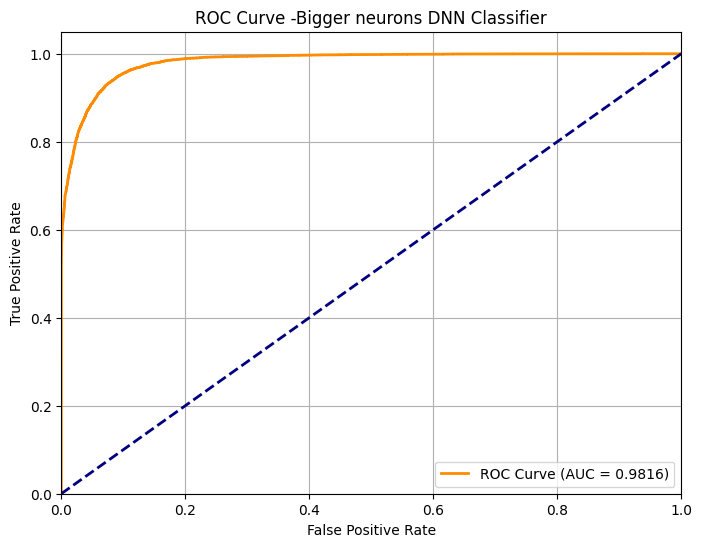

In [ ]:
pred = fcn_model.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -Bigger neurons DNN Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:

pred_df = fcn_model.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)
s
macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")


print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy:        0.9283
Macro Precision: 0.9287
Macro Recall:    0.9286
Macro F1-score:  0.9283


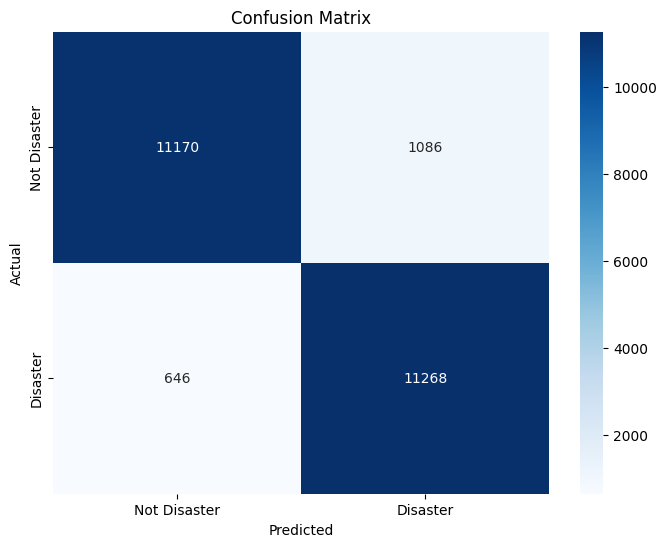

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## initial dropout

In [ ]:

fcn_model = H2ODeepLearningEstimator(
    hidden=[128, 64, 32, 16, 8],

    epochs=50,
    train_samples_per_iteration=-1,
    reproducible=True,
    seed=42,

    distribution="bernoulli",
    activation="RectifierWithDropout",
    hidden_dropout_ratios=[0.3, 0.2, 0.1, 0.1, 0.0],

    l1=1e-5,
    l2=1e-5,
    input_dropout_ratio=0.3,

    adaptive_rate=True,
    nesterov_accelerated_gradient=True,

    stopping_rounds=5,
    stopping_metric="AUC",
    stopping_tolerance=0.001,

    balance_classes=False,
    max_after_balance_size=1.0,

    model_id="5_layer_dnn_InitialDropout__classifier"
)


fcn_model.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

performance = fcn_model.model_performance(test_h2o)
print("Test Performance:")
print(performance)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Test Performance:
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.054053742840858926
RMSE: 0.23249460819739223
LogLoss: 0.1846364496621374
Mean Per-Class Error: 0.07350850015844623
AUC: 0.9808480543054203
AUCPR: 0.9806911366383202
Gini: 0.9616961086108406

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5743072132433675
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      11201  1055   0.0861   (1055.0/12256.0)
1      726    11188  0.0609   (726.0/11914.0)
Total  11927  12243  0.0737   (1781.0/24170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.574307     0.926274  204
max f2                       0.233638     0.953161  311
max f0point5                 0.771386  

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


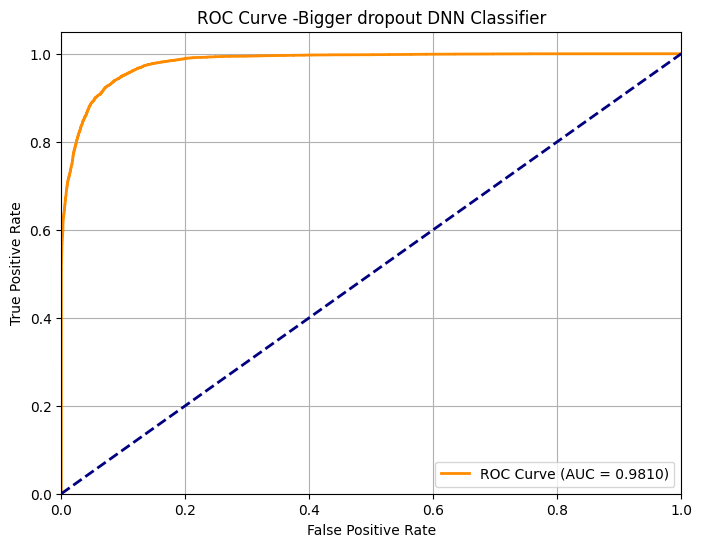

In [ ]:


pred = fcn_model.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -Bigger dropout DNN Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:


pred_df = fcn_model.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")


print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy:        0.9252
Macro Precision: 0.9257
Macro Recall:    0.9255
Macro F1-score:  0.9252


## model with accuracy validation

In [ ]:


fcn_model = H2ODeepLearningEstimator(
    hidden=[128, 64, 32, 16, 8],

    epochs=50,
    train_samples_per_iteration=-1,
    reproducible=True,
    seed=42,

    distribution="bernoulli",
    activation="RectifierWithDropout",
    hidden_dropout_ratios=[0.3, 0.2, 0.1, 0.1, 0.0],

    l1=1e-5,
    l2=1e-5,
    input_dropout_ratio=0.1,

    adaptive_rate=True,
    nesterov_accelerated_gradient=True,

    stopping_rounds=5,
    stopping_metric="misclassification",
    stopping_tolerance=0.001,

    balance_classes=False,
    max_after_balance_size=1.0,

    model_id="5_layer_dnn_validation_on_accuracy_classifier"
)


fcn_model.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

performance = fcn_model.model_performance(test_h2o)
print("Test Performance:")
print(performance)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Test Performance:
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.05346369202072326
RMSE: 0.23122217026211664
LogLoss: 0.18565053655342736
Mean Per-Class Error: 0.07206287000921749
AUC: 0.9812193030962543
AUCPR: 0.9809691667867882
Gini: 0.9624386061925085

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5358618861775505
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      11185  1071   0.0874   (1071.0/12256.0)
1      676    11238  0.0567   (676.0/11914.0)
Total  11861  12309  0.0723   (1747.0/24170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535862     0.927878  199
max f2                       0.207819     0.953685  301
max f0point5                 0.812345  

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


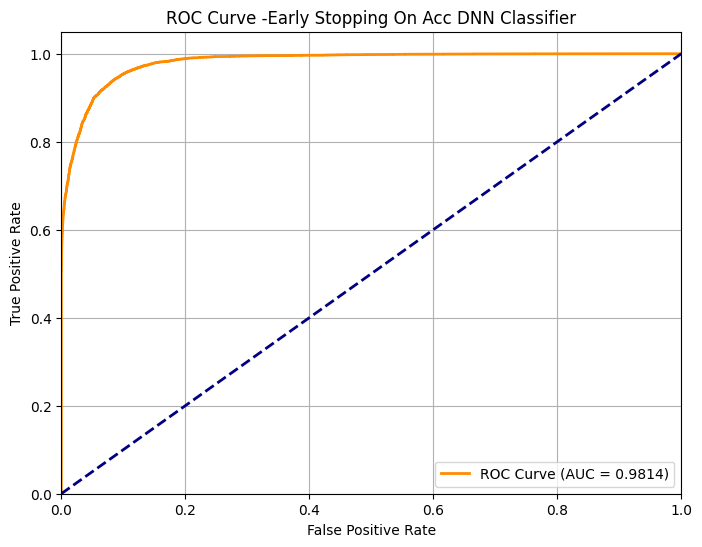

In [ ]:


pred = fcn_model.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -Early Stopping On Acc DNN Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
pred_df = fcn_model.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")


print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy:        0.9276
Macro Precision: 0.9277
Macro Recall:    0.9277
Macro F1-score:  0.9276


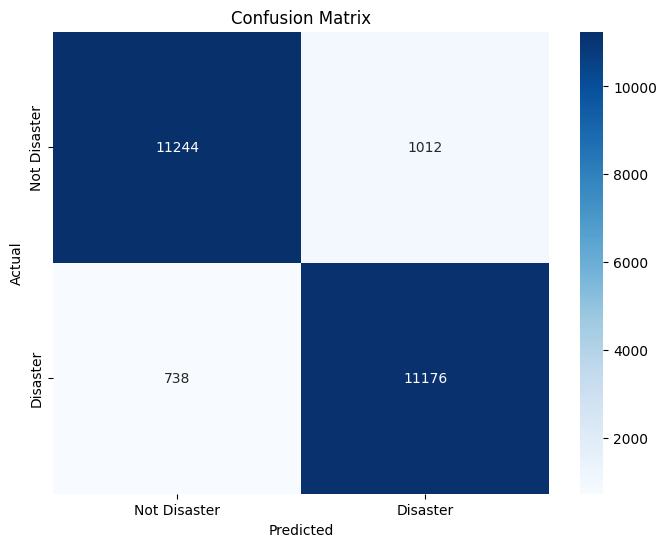

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<hr>
<hr>

## DNN with bigger dropout

In [ ]:
fcn_model = H2ODeepLearningEstimator(
    hidden=[128, 64, 32, 16, 8],

    epochs=50,
    train_samples_per_iteration=-1,
    reproducible=True,
    seed=42,

    distribution="bernoulli",
    activation="RectifierWithDropout",
    hidden_dropout_ratios=[0.4, 0.3, 0.1, 0.1, 0.0],

    l1=1e-5,
    l2=1e-5,
    input_dropout_ratio=0.1,

    adaptive_rate=True,
    nesterov_accelerated_gradient=True,

    stopping_rounds=5,
    stopping_metric="misclassification",
    stopping_tolerance=0.001,

    balance_classes=False,
    max_after_balance_size=1.0,

    model_id="5_layer_dnn_bigger_Dropout_classifier"
)


fcn_model.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

performance = fcn_model.model_performance(test_h2o)
print("Test Performance:")
print(performance)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Test Performance:
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.05334468751671079
RMSE: 0.23096468889575045
LogLoss: 0.18472918600151567
Mean Per-Class Error: 0.0720622947376126
AUC: 0.981105159621982
AUCPR: 0.9809264112585306
Gini: 0.9622103192439639

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5043072520698378
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      11077  1179   0.0962   (1179.0/12256.0)
1      571    11343  0.0479   (571.0/11914.0)
Total  11648  12522  0.0724   (1750.0/24170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504307     0.928384  219
max f2                       0.196826     0.95448   313
max f0point5                 0.818652    

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


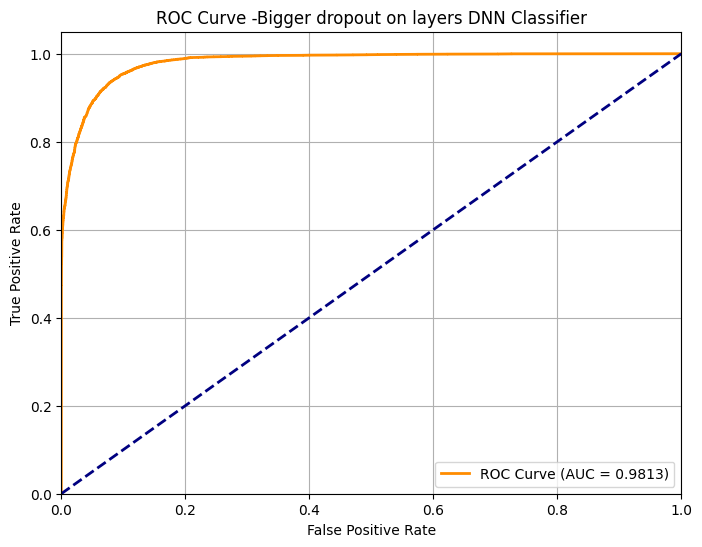

In [ ]:
pred = fcn_model.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -Bigger dropout on layers DNN Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
pred_df = fcn_model.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")


print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy:        0.9278
Macro Precision: 0.9280
Macro Recall:    0.9280
Macro F1-score:  0.9278


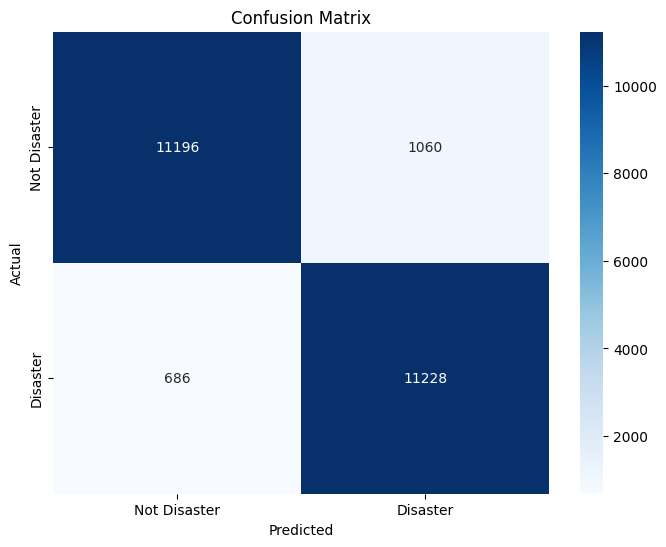

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<hr>
<hr>

In [ ]:
fcn_model = H2ODeepLearningEstimator(
    hidden=[128, 64, 32, 16, 8],

    epochs=50,
    train_samples_per_iteration=-1,
    reproducible=True,
    seed=42,

    distribution="bernoulli",
    activation="RectifierWithDropout",
    hidden_dropout_ratios=[0.4, 0.3, 0.2, 0.2, 0.0],

    l1=1e-5,
    l2=1e-5,
    input_dropout_ratio=0.1,

    adaptive_rate=True,
    nesterov_accelerated_gradient=True,

    stopping_rounds=5,
    stopping_metric="misclassification",
    stopping_tolerance=0.001,

    balance_classes=False,
    max_after_balance_size=1.0,

    model_id="5_layer_dnn_bigger_Dropout2_classifier"
)


fcn_model.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

performance = fcn_model.model_performance(test_h2o)
print("Test Performance:")
print(performance)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Test Performance:
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.05322917836770594
RMSE: 0.23071449535671992
LogLoss: 0.1853225074467884
Mean Per-Class Error: 0.07206970478376143
AUC: 0.9809391629458464
AUCPR: 0.9808452096054773
Gini: 0.9618783258916928

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4507753644114199
       0      1      Error    Rate
-----  -----  -----  -------  ----------------
0      11155  1101   0.0898   (1101.0/12256.0)
1      647    11267  0.0543   (647.0/11914.0)
Total  11802  12368  0.0723   (1748.0/24170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450775     0.928013  232
max f2                       0.132077     0.954345  332
max f0point5                 0.815276   

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


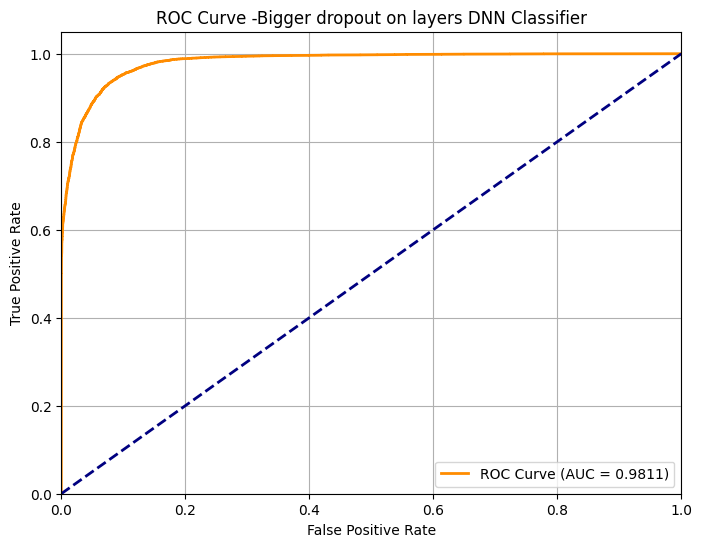

In [ ]:
pred = fcn_model.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -Bigger dropout on layers DNN Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:

pred_df = fcn_model.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")


print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Accuracy:        0.9269
Macro Precision: 0.9275
Macro Recall:    0.9272
Macro F1-score:  0.9268


<hr>
<hr>
<hr>

</hr>

# AUTO ML model


In [ ]:
h2o.init()


aml = H2OAutoML(
    max_models=20,
    seed=42,
    max_runtime_secs=3600,
    stopping_metric="AUC",
    stopping_rounds=5,
    stopping_tolerance=0.001,
    balance_classes=False,
    exclude_algos=["StackedEnsemble"],
    verbosity="info"
)
aml.train(
    y="label",
    training_frame=train_h2o,
    validation_frame=val_h2o
)

lb = aml.leaderboard
print(lb.head())

leader = aml.leader
performance = leader.model_performance(test_h2o)
print("\nTest Performance of Leader Model:")
print(performance)



Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,4 hours 7 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,"2 years, 1 month and 7 days"
H2O_cluster_name:,H2O_from_python_unknownUser_6sfo0e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.277 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


AutoML progress: |
02:39:15.156: Project: AutoML_1_20250417_23915
02:39:15.159: Blending will be used.
02:39:15.160: Stopping tolerance set by the user: 0.001
02:39:15.183: Stopping tolerance set by the user is < 70% of the recommended default of 0.003713701875296403, so models may take a long time to converge or may not converge at all.
02:39:15.183: Build control seed: 42
02:39:15.190: Since cross-validation is disabled, and blending frame(s) were not provided, automatically split the training data into training, blending frame(s) in the ratio 80/0/20.
02:39:24.654: training frame: Frame key: AutoML_1_20250417_23915_training_py_47_sid_9295    cols: 385    rows: 57899  chunks: 140    size: 181594108  checksum: 1302227940987399911
02:39:24.661: validation frame: Frame key: py_48_sid_9295    cols: 385    rows: 24170  chunks: 47    size: 75502619  checksum: -7211990487404036367
02:39:24.662: leaderboard frame: Frame key: py_48_sid_9295    cols: 385    rows: 24170  chunks: 47    size: 755

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


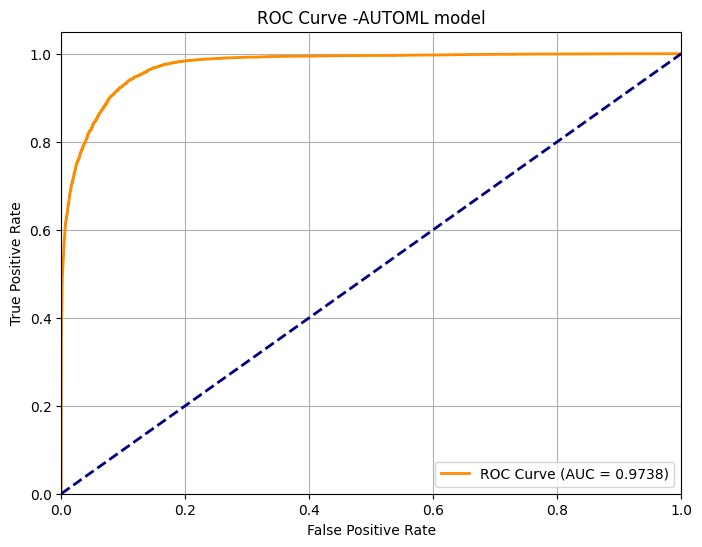

In [ ]:
pred = leader.predict(test_h2o).as_data_frame()

y_true = test_h2o["label"].as_data_frame().values.flatten().astype(int)
y_score = pred["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve -AUTOML model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:

pred_df = leader.predict(test_h2o).as_data_frame()
y_pred = pred_df["predict"].values
y_prob = pred_df["p1"].values
y_true = test_h2o["label"].as_data_frame().values.flatten()

accuracy = accuracy_score(y_true, y_pred)

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
macro_f1 = f1_score(y_true, y_pred, average="macro")


print(f"Accuracy:        {accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Accuracy:        0.9127
Macro Precision: 0.9146
Macro Recall:    0.9132
Macro F1-score:  0.9127


<hr>
<hr>
